In [1]:
import numpy as np
import pandas as pd

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

from pathlib import Path
import os
import os.path

from sklearn.model_selection import train_test_split

import uuid
import cv2
import random

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
base_path = 'HardHat_dataset/'
ann_path = base_path  + 'annotations/'
img_path = base_path + 'images/'

In [4]:
def get_train_df(ann_path, img_path):
    def get_file_list(root, file_type):
        return [os.path.join(directory_path, f) for directory_path, directory_name, files in os.walk(root) for f in files if f.endswith(file_type)]
    ann_path_list = get_file_list(ann_path, '.xml')
    ann_list = []

    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}

        ann['uuid'] = uuid.uuid1().int
        ann['filename'] = Path(str(img_path)+'/'+root.find("./filename").text)

        ann['width'] = root.find("./size/width").text
        ann['height'] = root.find("./size/height").text
        ann['depth'] = root.find("./size/depth").text

        for obj in root.findall('object'):
            ann['xmin'] = int(obj.find("bndbox").find('xmin').text)
            ann['ymin'] = int(obj.find("bndbox").find('ymin').text)
            ann['xmax'] = int(obj.find("bndbox").find('xmax').text)
            ann['ymax'] = int(obj.find("bndbox").find('ymax').text)
            
            ann_list.append(ann)

    return pd.DataFrame(ann_list)


In [5]:
df_train = get_train_df(ann_path, img_path)
print(df_train.head(10))

uuids = df_train.uuid.unique()

                                      uuid  \
0  231857179751650940529861379735676938468   
1  231857179751650940529861379735676938468   
2  231857179751650940529861379735676938468   
3  231857179751650940529861379735676938468   
4  231857179751650940529861379735676938468   
5  231857179751650940529861379735676938468   
6  231857179751650940529861379735676938468   
7  231857179751650940529861379735676938468   
8  231857179751650940529861379735676938468   
9  231857179751650940529861379735676938468   

                                       filename width height depth  xmin  \
0  HardHat_dataset\images\hard_hat_workers0.png   416    416     3   157   
1  HardHat_dataset\images\hard_hat_workers0.png   416    416     3   157   
2  HardHat_dataset\images\hard_hat_workers0.png   416    416     3   157   
3  HardHat_dataset\images\hard_hat_workers0.png   416    416     3   157   
4  HardHat_dataset\images\hard_hat_workers0.png   416    416     3   157   
5  HardHat_dataset\images\hard_hat_wo

In [6]:
class Mask_Aide():
    def bb_to_mask(self, bb, x):
        row, col, depth = x.shape
        Y = np.zeros((row,col))
        bb = bb.astype(np.int)
        Y[bb[0]:bb[2],bb[1]:bb[3]] = 1.
        return Y

    def mask_to_bb(self, Y):
        col, row = np.nonzero(Y)
        if len(col) == 0: return np.zeros(4, dtype = np.float32)
        top_row, bot_row = np.min(row), np.max(row)
        left_col, right_col = np.min(col), np.max(col)
        return np.array([left_col, top_row, right_col, bot_row], dtype = np.float32)
    
    def create_corner_rect(self , bb, color = 'red'):
        bb = np.array(bb, dtype=np.float32)
        return plt.Rectangle((bb[1],bb[0]),bb[3]-bb[1],bb[2]- bb[0], color = color, fill = False, lw=3)

    def show_corner_bb(self, im, bb):
        plt.imshow(im)
        plt.gca().add_patch(self.create_corner_rect(bb))
    

In [7]:
mask_aide = Mask_Aide()

In [8]:
class Resize():
    def __init__(self, df, new_path, mask_aide):
        self.df = df
        self.train_path_resized = Path(new_path)
        self.mask_aide = mask_aide
        self.resize()

    def read_image(self, path):
        return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

    def create_bb_array(self, x):
        return np.array([x[6], x[5], x[8], x[7]])
    
    def resize_image_bb(self, read_path, write_path, bb, sz):
        new_size = (int(1.49*sz),sz)
        im = self.read_image(read_path)

        im_resized = cv2.resize(im, new_size)
        Y_resized = cv2.resize(self.mask_aide.bb_to_mask(bb, im), new_size)

        new_path = str(write_path/read_path.parts[-1])

        file = Path(new_path)
        if not file.is_file():
            cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))

        return new_path, self.mask_aide.mask_to_bb(Y_resized)
    
    def resize(self):
        new_paths = []
        new_bbs = []

        for index, row in self.df.iterrows():
            new_path, new_bb = self.resize_image_bb(row['filename'], self.train_path_resized, self.create_bb_array(row.values),300)
            new_paths.append(new_path)
            new_bbs.append(new_bb)
        self.df['new_path'] = new_paths
        self.df['new_bb'] = new_bbs

In [9]:
!rmdir -rf images_resized 
!mkdir images_resized

The system cannot find the file specified.
The system cannot find the file specified.


In [10]:
resized = Resize(df_train, 'images_resized', mask_aide)
resized.df.head()

,uuid,filename,width,height,depth,xmin,ymin,xmax,ymax,new_path,new_bb
0,231857179751650940529861379735676938468,HardHat_dataset\images\hard_hat_workers0.png,416,416,3,157,150,175,177,images_resized\hard_hat_workers0.png,"[108.0, 168.0, 127.0, 188.0]"
1,231857179751650940529861379735676938468,HardHat_dataset\images\hard_hat_workers0.png,416,416,3,157,150,175,177,images_resized\hard_hat_workers0.png,"[108.0, 168.0, 127.0, 188.0]"
2,231857179751650940529861379735676938468,HardHat_dataset\images\hard_hat_workers0.png,416,416,3,157,150,175,177,images_resized\hard_hat_workers0.png,"[108.0, 168.0, 127.0, 188.0]"
3,231857179751650940529861379735676938468,HardHat_dataset\images\hard_hat_workers0.png,416,416,3,157,150,175,177,images_resized\hard_hat_workers0.png,"[108.0, 168.0, 127.0, 188.0]"
4,231857179751650940529861379735676938468,HardHat_dataset\images\hard_hat_workers0.png,416,416,3,157,150,175,177,images_resized\hard_hat_workers0.png,"[108.0, 168.0, 127.0, 188.0]"


In [11]:
class Augmentation():
    def __init__(self, mask_aide):
        self.mask_aide = mask_aide

    def crop(self, im, r, c, target_r, target_c):
        return im[r:r+target_r, c:c+target_c]

    def random_crop(self, x , r_pix = 8):
        r, c, *_ = x.shape
        c_pix = round(r_pix*c/r)
        rand_r = random.uniform(0,1)
        rand_c = random.uniform(0,1)
        start_r = np.floor(2*rand_r*r_pix).astype(int)
        start_c = np.floor(2*rand_c*c_pix).astype(int)
        return self.crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)       

    def center_crop(self, x, r_pix = 8):
        r, c, *_ = x.shape
        c_pix = round(r_pix*c/r)
        return self.crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

    def random_cropXY(self, x, Y, r_pix=8):
        r, c, *_ = x.shape
        c_pix = round(r_pix*c/r)
        rand_r = random.uniform(0,1)
        rand_c = random.uniform(0,1)
        start_r = np.floor(2*rand_r*r_pix).astype(int)
        start_c = np.floor(2*rand_c*c_pix).astype(int)
        xx = self.crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
        YY = self.crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
        return xx, YY

    def rotate_cv(seld, im, deg, y=False, mode = cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
        r, c, *_ = im.shape
        M = cv2.getRotationMatrix2D((c/2,r/2), deg, 1)
        if y:
            return cv2. warpAffine(im, M, (c,r), borderMode = cv2.BORDER_CONSTANT)
        
        return cv2.warpAffine(im, M, (c,r), borderMode = mode, flags = cv2.WARP_FILL_OUTLIERS + interpolation)

    def transformsXY(self , path, bb, transforms):
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        Y = self.mask_aide.bb_to_mask(bb, x)
        if transforms:
            rdeg = (np.random.random()-.50)*20
            x = self.rotate_cv(x,rdeg)
            Y = self.rotate_cv(Y, rdeg, y=True)
            if np.random.random() > 0.5:
                x = np.fliplr(x).copy()
                Y = np.fliplr(Y).copy()
            x,Y = self.random_cropXY(x,Y)
        else:
            x, Y = self.center_crop(x) , self.center_crop(Y)
        return x, self.mask_aide.mask_to_bb(Y)

In [12]:
augmentations = Augmentation(mask_aide)

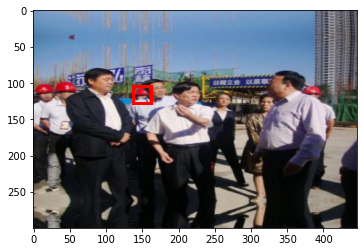

In [13]:
img = cv2.imread(str(df_train.values[120][-2]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_aide.show_corner_bb(img, df_train.values[120][-1])

In [14]:
class HardHatDataset(Dataset):
    def __init__(self, paths, bb, augmentations, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.augmentations = augmentations

    def normalize(self, im):
        imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
        return (im - imagenet_stats[0])/imagenet_stats[1]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        x, y_bb = self.augmentations.transformsXY(path, self.bb[index], self.transforms)
        x = self.normalize(x)
        x = np.rollaxis(x,2)
        return x, y_bb


In [15]:
resized_df = resized.df.reset_index()
features = resized_df[['new_path', 'new_bb']]

In [16]:
X_train, X_test = train_test_split(features, test_size = 0.25, random_state=34)

In [17]:
batch_size = 64
train_ds = HardHatDataset(X_train['new_path'], X_train['new_bb'], augmentations, transforms=True)
test_ds = HardHatDataset(X_test['new_path'], X_test['new_bb'], augmentations)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)